# Data Scientist Challenge Latam Airlines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import re

## Data loading

Below we create a dictionary with dtypes because pandas gives a warning with the columns Vlo-I and Vlo-O, some values are not just numbers, some numbers include letters.

In [2]:
dtypes = {
    'Fecha-I' : 'str',
    'Vlo-I' : 'str',
    'Ori-I' : 'str',
    'Des-I' : 'str',
    'Emp-I' : 'str',
    'Fecha-O' : 'str',
    'Vlo-O' : 'str',
    'Ori-O' : 'str',
    'Des-O' : 'str',
    'Emp-O' : 'str',
    'DIA' : 'int32',
    'MES' : 'int32',
    'AÑO' : 'int32',
    'DIANOM' : 'str',
    'TIPOVUELO' : 'str',
    'OPERA' : 'str',
    'SIGLAORI' : 'str',
    'SIGLADES' : 'str'
}

In [93]:
data = pd.read_csv("dataset_SCL.csv", dtype = dtypes)

#Change the format of the 'Fecha-I' column to datetime
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"], format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"], format="%Y-%m-%d %H:%M:%S")

With the data loaded, we can show a few of them, to see what we are working with

In [94]:
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


We can show a describe of the pandas DataFrame to see the statistics of the data, but almost all columns are strings, so is not useful.

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int32         
 11  MES        68206 non-null  int32         
 12  AÑO        68206 non-null  int32         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

We can see that there are 1 column with only one missing value. We can drop it or fill it. But we can see that the column 'Vlo-I' is the same of 'Vlo-O', so we can fill it with that value. But to show this, we have to transform both columns

In [96]:
def transformation(value):
    try:
        return str(int(float(value)))
    except:
        return value

In [97]:
data["Vlo-I"] = data["Vlo-I"].apply(transformation)
data["Vlo-O"] = data["Vlo-O"].apply(transformation)

Now we can show how many rows have 'Vlo-I' value containing a letter

In [98]:
data[data["Vlo-I"].str.contains("[a-zA-Z]", regex = True)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
27464,2017-06-16 20:30:00,940P,SCEL,KDFW,AAL,2017-06-16 20:50:00,940,SCEL,KDFW,AAL,16,6,2017,Viernes,I,American Airlines,Santiago,Dallas
39225,2017-08-07 19:00:00,591P,SCEL,LFPG,PUE,2017-08-07 20:35:00,591P,SCEL,LFPG,PUE,7,8,2017,Lunes,I,Plus Ultra Lineas Aereas,Santiago,Paris
39266,2017-08-24 23:00:00,846A,SCEL,KIAH,UAL,2017-08-24 23:00:00,2804,SCEL,KIAH,UAL,24,8,2017,Jueves,I,United Airlines,Santiago,Houston
58126,2017-11-05 17:00:00,1104A,SCEL,SCSE,SKU,2017-11-05 17:42:00,1104,SCEL,SCSE,SKU,5,11,2017,Domingo,N,Sky Airline,Santiago,La Serena


Given that the 'Vlo-I' have only 5 rows with letters, we can remove the letters and keep the numbers.

In [99]:
data["Vlo-I"] = data["Vlo-I"].apply(lambda x : re.sub("[a-zA-Z]", "", x)).astype("int32")

We can make same analysis of the other columns like ("Ori-I", "Ori-O"), ("Des-I", "Des-O") and ("Emp-I", "Emp-O"), but first we see how many pair values are the same:

In [100]:
columns = [("Ori-I", "Ori-O"), ("Des-I", "Des-O"), ("Emp-I", "Emp-O")]
for col1, col2 in columns:
    print(f"For {col1} and {col2} : {data[data.apply(lambda x : x[col1] != x[col2], axis = 1)].shape[0]} of {data.shape[0]} different values")

For Ori-I and Ori-O : 0 of 68206 different values
For Des-I and Des-O : 28 of 68206 different values
For Emp-I and Emp-O : 18669 of 68206 different values


This shows that are columns with redundant information, so in the future we can drop them.

## 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

Below we will avoid to include analysis that does not involve the delay of the flights.

In [114]:
data_aux = data.copy()
data_aux["fecha"] = data_aux.apply(lambda x : f"{x['AÑO']}-{x['MES']}-{x['DIA']}", axis = 1)
data_aux["fecha"] = pd.to_datetime(data_aux["fecha"], format="%Y-%m-%d")
data_aux["dia_semana"] = data_aux["DIANOM"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'].index(x))

In [115]:
data_aux["delay"] = (data_aux["Fecha-O"] - data_aux["Fecha-I"]).dt.total_seconds()

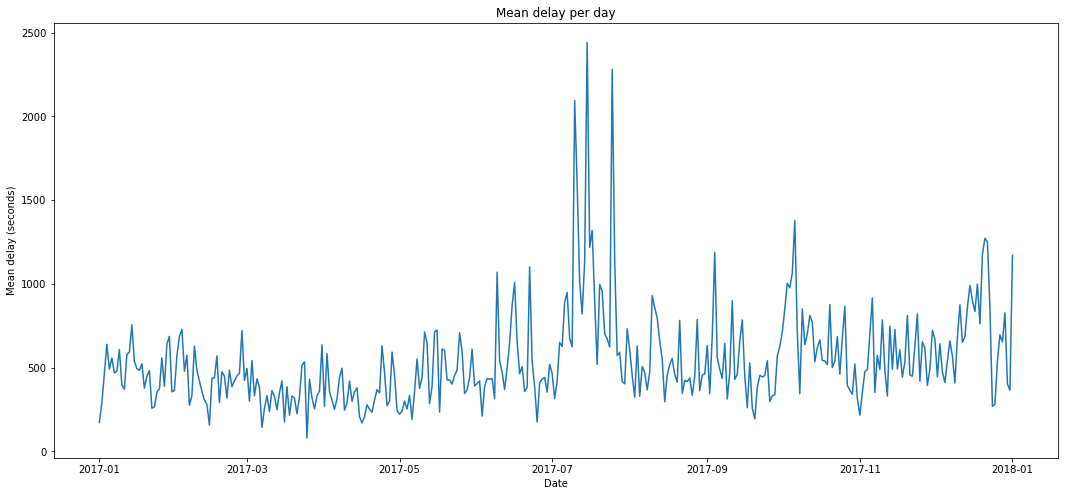

In [119]:
aux = data_aux.groupby("fecha").agg({"delay" : "mean"}).reset_index()
plt.figure(figsize = (18, 8))
plt.plot(aux["fecha"], aux["delay"])
plt.xlabel("Date")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per day")
plt.show()

We can see that there are no visible patterns in the data except for the obvious rise in July. However, this behavior can be explained by the increase in the number of flights during that month, as shown in the next graph.

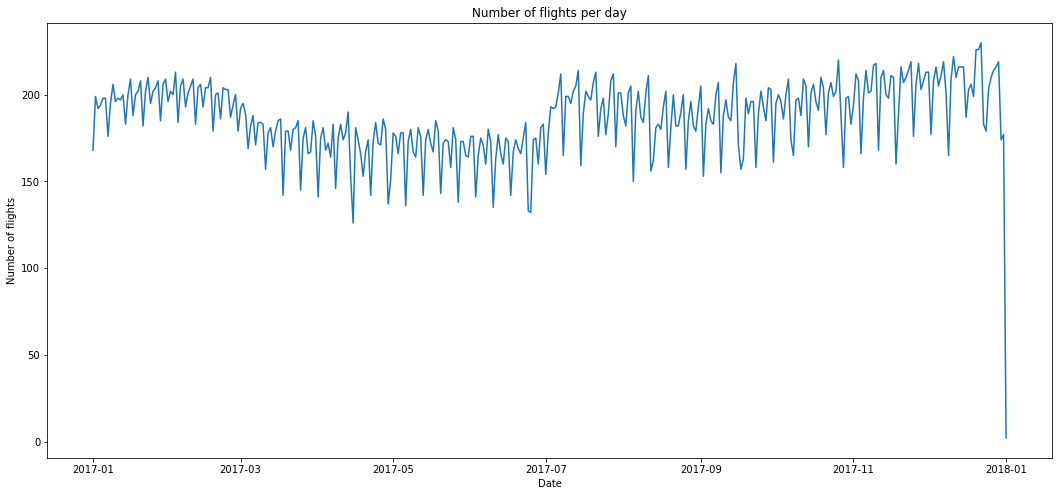

In [126]:
aux = data_aux.groupby("fecha").count().reset_index()[["fecha", "Fecha-I"]]
plt.figure(figsize = (18, 8))
plt.plot(aux["fecha"], aux["Fecha-I"])
plt.xlabel("Date")
plt.ylabel("Number of flights")
plt.title("Number of flights per day")
plt.show()

As additional analysis, we can see that there is a pattern in the number of flights per day, which can be related to the day of the week. But this is not in the scope of this exercise, so we will not analyze it in detail.

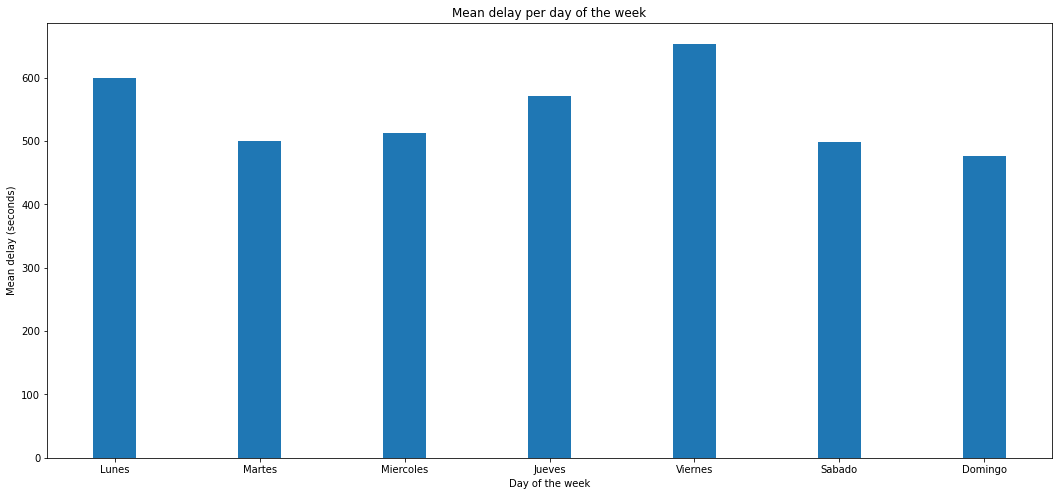

In [133]:
aux = data_aux.groupby("dia_semana").agg({"delay" : "mean"}).reset_index()
aux["dia_semana"] = aux["dia_semana"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'][x])
plt.figure(figsize = (18, 8))
plt.bar(aux["dia_semana"], aux["delay"], width = 0.3)
plt.xlabel("Day of the week")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per day of the week")
plt.show()

From this graph, we can see that the mean delay is higher on Friday and Monday and lower on Saturday and Sunday. This behavior can be explained by the same idea mentioned previously, that an increase in the number of flights can lead to an increase in delays. This can be confirmed by examining the number of flights per day of the week.

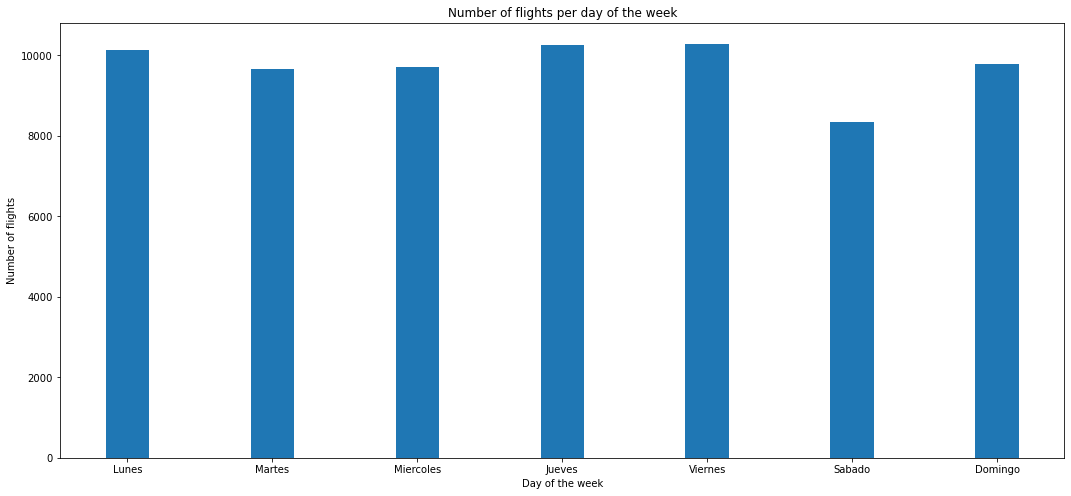

In [134]:
aux = data_aux.groupby("dia_semana").count().reset_index()[["dia_semana", "Fecha-I"]]
aux["dia_semana"] = aux["dia_semana"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'][x])
plt.figure(figsize = (18, 8))
plt.bar(aux["dia_semana"], aux["Fecha-I"], width = 0.3)
plt.xlabel("Day of the week")
plt.ylabel("Number of flights")
plt.title("Number of flights per day of the week")
plt.show()

This graph shows us that on Monday, Thursday, and Friday, there are more flights than on the other days, while on Saturday, there are fewer flights. This can be explained by the fact that many people travel for the weekend, so they travel on Friday and return on Monday or Sunday. This leads us to think that the delay time actually increases when the demand for air travel increases.

Another possible relationship is between the delay and the type of flight, so we will analyze it.

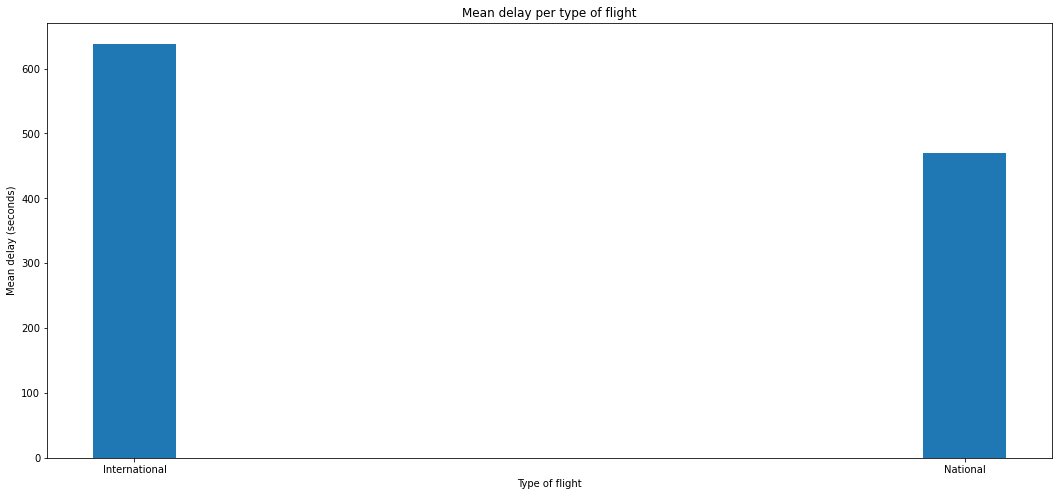

In [141]:
aux = data_aux.groupby("TIPOVUELO").agg({"delay" : "mean"}).reset_index()
aux["TIPOVUELO"] = aux["TIPOVUELO"].apply(lambda x : {'I' : 'International', 'N' : 'National'}[x])
plt.figure(figsize = (18, 8))
plt.bar(aux["TIPOVUELO"], aux["delay"], width = 0.1)
plt.xlabel("Type of flight")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per type of flight")
plt.show()

This shows that the delay may be related to the type of flight, because the mean delay is higher for international flights, wich can be logical because they can have more bureaucratic processes.

Now we will analyze if the destination airport has an impact on the delay

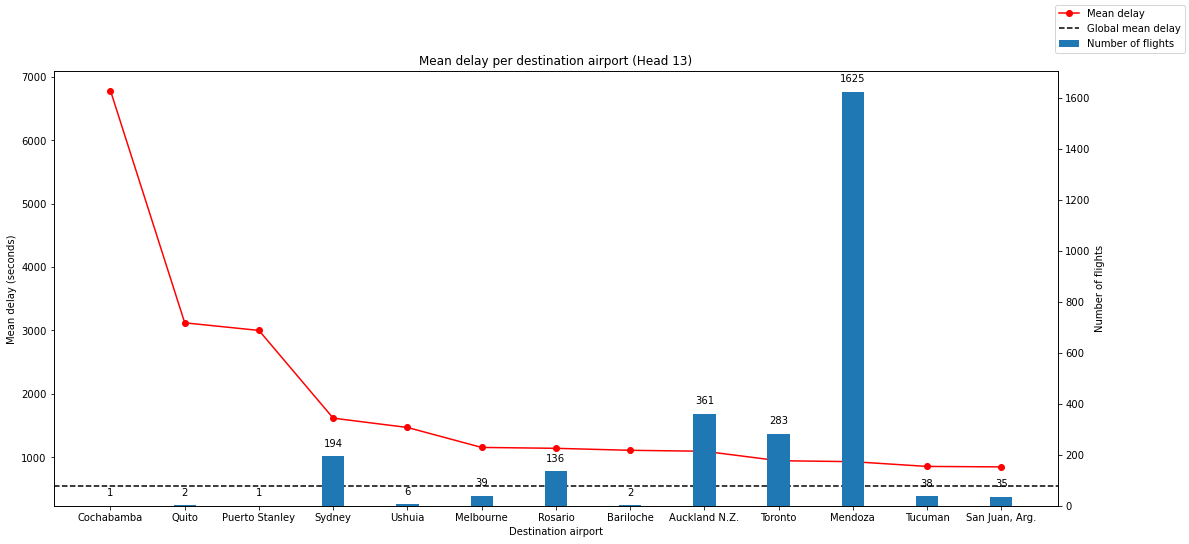

In [197]:
aux_delay = data_aux.groupby("SIGLADES").agg({"delay" : "mean", 'MES' : 'count'}).reset_index().sort_values("delay", ascending = False).head(13)

fig, ax1 = plt.subplots(figsize = (18, 8))
ax1.plot(aux_delay["SIGLADES"], aux_delay["delay"],color = "red", marker = "o", label = "Mean delay")
ax1.set_xlabel("Destination airport")
ax1.set_ylabel("Mean delay (seconds)")
ax1.set_title("Mean delay per destination airport (Head 13)")

ax2 = ax1.twinx()
ax2.bar(aux_delay["SIGLADES"], aux_delay["MES"], width = 0.3, label = "Number of flights")
ax2.set_ylabel("Number of flights")

for x, y in zip(aux_delay["SIGLADES"], aux_delay["MES"]):
    ax2.annotate(str(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

ax1.axhline(data_aux["delay"].mean(), color = "black", linestyle = "--", label = "Global mean delay")

fig.legend(loc = "upper right")
plt.show()

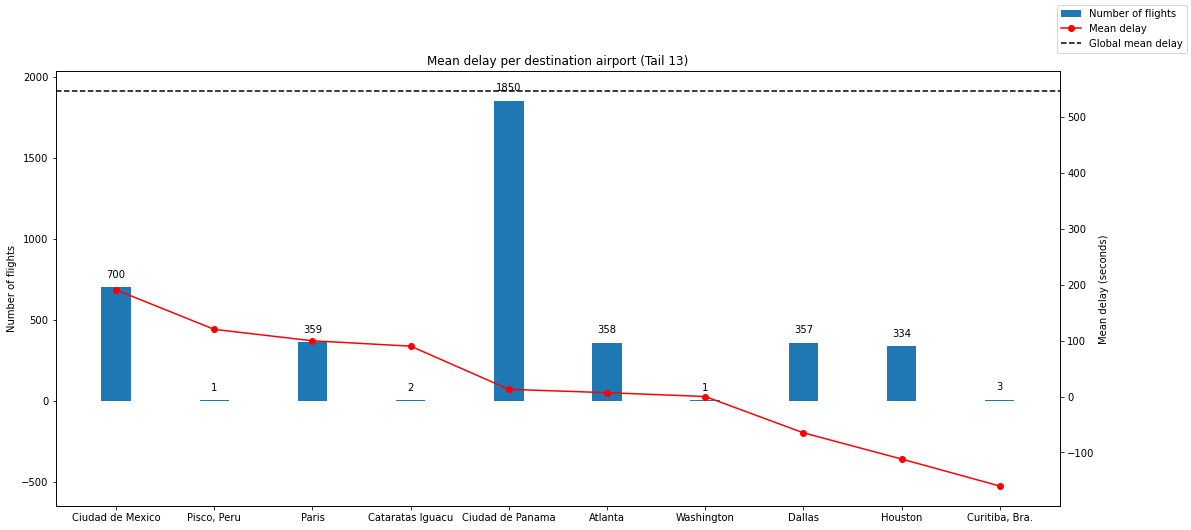

In [210]:
aux_delay = data_aux.groupby("SIGLADES").agg({"delay" : "mean", 'MES' : 'count'}).reset_index().sort_values("delay", ascending = False).tail(10)

fig, ax1 = plt.subplots(figsize = (18, 8))

ax1.bar(aux_delay["SIGLADES"], aux_delay["MES"], width = 0.3, label = "Number of flights")
ax1.set_ylabel("Number of flights")

gap = 650
ax1.set_ylim([-gap, aux_delay["MES"].max()*1.1])

for x, y in zip(aux_delay["SIGLADES"], aux_delay["MES"]):
    ax1.annotate(str(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

ax2 = ax1.twinx()

ax2.plot(aux_delay["SIGLADES"], aux_delay["delay"], color = "red", marker = "o", label = "Mean delay")
ax2.set_xlabel("Destination airport")
ax2.set_ylabel("Mean delay (seconds)")
ax2.set_title("Mean delay per destination airport (Tail 13)")

ax2.axhline(data_aux["delay"].mean(), color = "black", linestyle = "--", label = "Global mean delay")

fig.legend(loc = "upper right")
plt.show()

With these two graphs, we can see that there are some airports that consistently have significantly fewer delays than the global mean delay. However, we cannot be certain that the destination is always a significant factor in the delay of the flight because some destinations do not have enough data.

All these analysis can be made with the 'SIGLAORI' column, but the only origin airport is 'Santiago' as we can see in the next cell

In [212]:
data_aux["SIGLAORI"].unique()

array(['Santiago'], dtype=object)

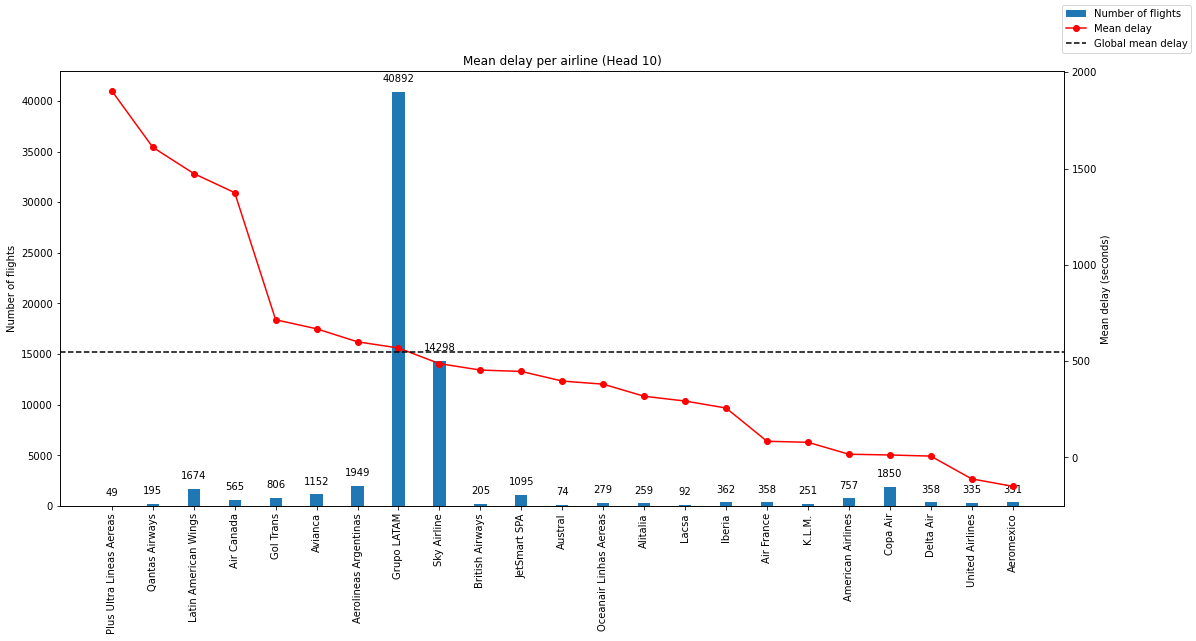

In [227]:
#Other analysis we can do is to see the delay per airline 'OPERA'

aux_delay = data_aux.groupby("OPERA").agg({"delay" : "mean", 'MES' : 'count'}).reset_index().sort_values("delay", ascending = False)

fig, ax1 = plt.subplots(figsize = (18, 8))
ax2 = ax1.twinx()

ax2.plot(aux_delay["OPERA"], aux_delay["delay"],color = "red", marker = "o", label = "Mean delay")
ax2.set_xlabel("Airline")
ax2.set_ylabel("Mean delay (seconds)")
ax2.set_title("Mean delay per airline (Head 10)")

ax1.bar(aux_delay["OPERA"], aux_delay["MES"], width = 0.3, label = "Number of flights")
ax1.set_ylabel("Number of flights")

for x, y in zip(aux_delay["OPERA"], aux_delay["MES"]):
    ax1.annotate(str(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

ax2.axhline(data_aux["delay"].mean(), color = "black", linestyle = "--", label = "Global mean delay")

ax1.set_xticks(range(len(aux_delay["OPERA"])))
ax1.set_xticklabels(aux_delay["OPERA"], rotation=90)

fig.legend(loc = "upper right")
plt.show()

Here we clearly see that the airline distribution is unbalanced, with only two airlines dominating the dataset. However, we can also observe that some airlines have significantly higher delays than the global mean delay, indicating that the airline may be a significant factor in the delay in some cases.

In [230]:
del data_aux

## 2. Generate the following additional columns.

Please export them to a CSV file named synthetic_features.csv:
  - high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
  - min_diff : difference in minutes between Date-O and Date-I .
  - delay_15 : 1 if min_diff > 15, 0 if not.
  - period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I.

In [240]:
def high_season(date):
    dec_15 = pd.Timestamp(date.year, 12, 15)
    mar_3 = pd.Timestamp(date.year, 3, 3)

    jul_15 = pd.Timestamp(date.year, 7, 15)
    jul_31 = pd.Timestamp(date.year, 7, 31)

    sep_11 = pd.Timestamp(date.year, 9, 11)
    sep_30 = pd.Timestamp(date.year, 9, 30)

    return int((dec_15 <= date <= mar_3) or (jul_15 <= date <= jul_31) or (sep_11 <= date <= sep_30))

def period_day(date):
    morning_start = pd.Timestamp(date.year, date.month, date.day, 5, 0)
    morning_end = pd.Timestamp(date.year, date.month, date.day, 11, 59)

    afternoon_start = pd.Timestamp(date.year, date.month, date.day, 12, 0)
    afternoon_end = pd.Timestamp(date.year, date.month, date.day, 18, 59)

    if morning_start <= date <= morning_end:
        return "morning"
    elif afternoon_start <= date <= afternoon_end:
        return "afternoon"
    else:
        return "night"

In [242]:
data["high_season"] = data["Fecha-I"].apply(high_season)
data["min_diff"] = data.apply(lambda x : (x["Fecha-O"] - x["Fecha-I"]).total_seconds() / 60, axis = 1)
data["delay_15"] = data["min_diff"].apply(lambda x : int(x > 15))
data["period_day"] = data["Fecha-I"].apply(period_day)

In [244]:
data.to_csv("synthetic_features.csv", index = False)

## 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?